[![Open in Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/langchain-ai/langchain-academy/blob/main/module-2/state-reducers.ipynb) [![Open in LangChain Academy](https://cdn.prod.website-files.com/65b8cd72835ceeacd4449a53/66e9eba12c7b7688aa3dbb5e_LCA-badge-green.svg)](https://academy.langchain.com/courses/take/intro-to-langgraph/lessons/58239428-lesson-2-state-reducers)

# State Reducers

## Review

We covered a few different ways to define LangGraph state schema, including `TypedDict`, `Pydantic`, or `Dataclasses`.

## Goals

Now, we're going to dive into reducers, which specify how state updates are performed on specific keys / channels in the state schema.

In [ ]:
%%capture --no-stderr
%pip install --quiet -U langchain_core langgraph

## Default overwriting state

Let's use a `TypedDict` as our state schema.

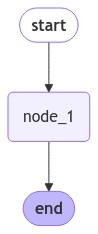

In [ ]:
from typing_extensions import TypedDict
from IPython.display import Image, display
from langgraph.graph import StateGraph, START, END

class State(TypedDict):
    foo: int

def node_1(state):
    print("---Node 1---")
    return {"foo": state['foo'] + 1}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
graph.invoke({"foo" : 1})

---Node 1---


{'foo': 2}

Let's look at the state update, `return {"foo": state['foo'] + 1}`.

As discussed before, by default LangGraph doesn't know the preferred way to update the state.

So, it will just overwrite the value of `foo` in `node_1`:

```
return {"foo": state['foo'] + 1}
```

If we pass `{'foo': 1}` as input, the state returned from the graph is `{'foo': 2}`.

## Branching

Let's look at a case where our nodes branch.

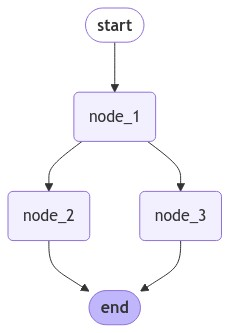

In [ ]:
class State(TypedDict):
    foo: int

def node_1(state):
    print("---Node 1---")
    return {"foo": state['foo'] + 1}

def node_2(state):
    print("---Node 2---")
    return {"foo": state['foo'] + 1}

def node_3(state):
    print("---Node 3---")
    return {"foo": state['foo'] + 1}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
from langgraph.errors import InvalidUpdateError
try:
    graph.invoke({"foo" : 1})
except InvalidUpdateError as e:
    print(f"InvalidUpdateError occurred: {e}")


---Node 1---
---Node 2---
---Node 3---
InvalidUpdateError occurred: At key 'foo': Can receive only one value per step. Use an Annotated key to handle multiple values.


We see a problem!

Node 1 branches to nodes 2 and 3.

Nodes 2 and 3 run in parallel, which means they run in the same step of the graph.

They both attempt to overwrite the state *within the same step*.

This is ambiguous for the graph! Which state should it keep?

## Reducers

[Reducers](https://langchain-ai.github.io/langgraph/concepts/low_level/#reducers) give us a general way to address this problem.

They specify how to perform updates.

We can use the `Annotated` type to specify a reducer function.

For example, in this case let's append the value returned from each node rather than overwriting them.

We just need a reducer that can perform this: `operator.add` is a function from Python's built-in operator module.

When `operator.add` is applied to lists, it performs list concatenation.

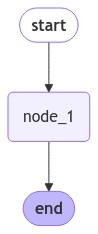

In [ ]:
from operator import add
from typing import Annotated

class State(TypedDict):
    foo: Annotated[list[int], add]

def node_1(state):
    print("---Node 1---")
    return {"foo": [state['foo'][0] + 1]}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

In [ ]:
graph.invoke({"foo" : [1]})

---Node 1---


{'foo': [1, 2]}

Now, our state key `foo` is a list.

This `operator.add` reducer function will append updates from each node to this list.

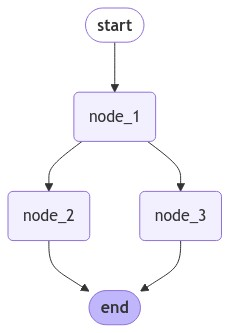

In [ ]:
def node_1(state):
    print("---Node 1---")
    return {"foo": [state['foo'][-1] + 1]}

def node_2(state):
    print("---Node 2---")
    return {"foo": [state['foo'][-1] + 1]}

def node_3(state):
    print("---Node 3---")
    return {"foo": [state['foo'][-1] + 1]}

# Build graph
builder = StateGraph(State)
builder.add_node("node_1", node_1)
builder.add_node("node_2", node_2)
builder.add_node("node_3", node_3)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", "node_2")
builder.add_edge("node_1", "node_3")
builder.add_edge("node_2", END)
builder.add_edge("node_3", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

We can see that updates in nodes 2 and 3 are performed concurrently because they are in the same step.

In [ ]:
graph.invoke({"foo" : [1]})

---Node 1---
---Node 2---
---Node 3---


{'foo': [1, 2, 3, 3]}

Now, let's see what happens if we pass `None` to `foo`.

We see an error because our reducer, `operator.add`, attempts to concatenate `NoneType` pass as input to list in `node_1`.

In [ ]:
try:
    graph.invoke({"foo" : None})
except TypeError as e:
    print(f"TypeError occurred: {e}")

TypeError occurred: can only concatenate list (not "NoneType") to list


## Custom Reducers

To address cases like this, [we can also define custom reducers](https://langchain-ai.github.io/langgraph/how-tos/subgraph/#custom-reducer-functions-to-manage-state).

For example, lets define custom reducer logic to combine lists and handle cases where either or both of the inputs might be `None`.

In [ ]:
def reduce_list(left: list | None, right: list | None) -> list:
    """Safely combine two lists, handling cases where either or both inputs might be None.

    Args:
        left (list | None): The first list to combine, or None.
        right (list | None): The second list to combine, or None.

    Returns:
        list: A new list containing all elements from both input lists.
               If an input is None, it's treated as an empty list.
    """
    if not left:
        left = []
    if not right:
        right = []
    return left + right

class DefaultState(TypedDict):
    foo: Annotated[list[int], add]

class CustomReducerState(TypedDict):
    foo: Annotated[list[int], reduce_list]

In `node_1`, we append the value 2.

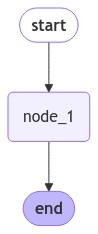

TypeError occurred: can only concatenate list (not "NoneType") to list


In [ ]:
def node_1(state):
    print("---Node 1---")
    return {"foo": [2]}

# Build graph
builder = StateGraph(DefaultState)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

try:
    print(graph.invoke({"foo" : None}))
except TypeError as e:
    print(f"TypeError occurred: {e}")

Now, try with our custom reducer. We can see that no error is thrown.

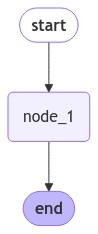

---Node 1---
{'foo': [2]}


In [ ]:
# Build graph
builder = StateGraph(CustomReducerState)
builder.add_node("node_1", node_1)

# Logic
builder.add_edge(START, "node_1")
builder.add_edge("node_1", END)

# Add
graph = builder.compile()

# View
display(Image(graph.get_graph().draw_mermaid_png()))

try:
    print(graph.invoke({"foo" : None}))
except TypeError as e:
    print(f"TypeError occurred: {e}")

## Messages

In module 1, we showed how to use a built-in reducer, `add_messages`, to handle messages in state.

We also showed that [`MessagesState` is a useful shortcut if you want to work with messages](https://langchain-ai.github.io/langgraph/concepts/low_level/#messagesstate).

* `MessagesState` has a built-in `messages` key
* It also has a built-in `add_messages` reducer for this key

These two are equivalent.

We'll use the `MessagesState` class via `from langgraph.graph import MessagesState` for brevity.


In [ ]:
from typing import Annotated
from langgraph.graph import MessagesState
from langchain_core.messages import AnyMessage
from langgraph.graph.message import add_messages

# Define a custom TypedDict that includes a list of messages with add_messages reducer
class CustomMessagesState(TypedDict):
    messages: Annotated[list[AnyMessage], add_messages]
    added_key_1: str
    added_key_2: str
    # etc

# Use MessagesState, which includes the messages key with add_messages reducer
class ExtendedMessagesState(MessagesState):
    # Add any keys needed beyond messages, which is pre-built
    added_key_1: str
    added_key_2: str
    # etc

Let's talk a bit more about usage of the `add_messages` reducer.

In [ ]:
from langgraph.graph.message import add_messages
from langchain_core.messages import AIMessage, HumanMessage

# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance")
                   ]

# New message to add
new_message = AIMessage(content="Sure, I can help with that. What specifically are you interested in?", name="Model")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', name='Model', id='f470d868-cf1b-45b2-ae16-48154cd55c12'),
 HumanMessage(content="I'm looking for information on marine biology.", name='Lance', id='a07a88c5-cb2a-4cbd-9485-5edb9d658366'),
 AIMessage(content='Sure, I can help with that. What specifically are you interested in?', name='Model', id='7938e615-86c2-4cbb-944b-c9b2342dee68')]

So we can see that `add_messages` allows us to append messages to the `messages` key in our state.

### Re-writing

Let's show some useful tricks when working with the `add_messages` reducer.

If we pass a message with the same ID as an existing one in our `messages` list, it will get overwritten!

In [ ]:
# Initial state
initial_messages = [AIMessage(content="Hello! How can I assist you?", name="Model", id="1"),
                    HumanMessage(content="I'm looking for information on marine biology.", name="Lance", id="2")
                   ]

# New message to add
new_message = HumanMessage(content="I'm looking for information on whales, specifically", name="Lance", id="2")

# Test
add_messages(initial_messages , new_message)

[AIMessage(content='Hello! How can I assist you?', name='Model', id='1'),
 HumanMessage(content="I'm looking for information on whales, specifically", name='Lance', id='2')]

### Removal

`add_messages` also [enables message removal](https://langchain-ai.github.io/langgraph/how-tos/memory/delete-messages/).

For this, we simply use [RemoveMessage](https://api.python.langchain.com/en/latest/messages/langchain_core.messages.modifier.RemoveMessage.html) from `langchain_core`.

In [ ]:
from langchain_core.messages import RemoveMessage

# Message list
messages = [AIMessage("Hi.", name="Bot", id="1")]
messages.append(HumanMessage("Hi.", name="Lance", id="2"))
messages.append(AIMessage("So you said you were researching ocean mammals?", name="Bot", id="3"))
messages.append(HumanMessage("Yes, I know about whales. But what others should I learn about?", name="Lance", id="4"))

# Isolate messages to delete
delete_messages = [RemoveMessage(id=m.id) for m in messages[:-2]]
print(delete_messages)

[RemoveMessage(content='', id='1'), RemoveMessage(content='', id='2')]


/var/folders/l9/bpjxdmfx7lvd1fbdjn38y5dh0000gn/T/ipykernel_17703/3097054180.py:10: LangChainBetaWarning: The class `RemoveMessage` is in beta. It is actively being worked on, so the API may change.
  delete_messages = [RemoveMessage(id=m.id) for m in messages[:-2]]


In [ ]:
add_messages(messages , delete_messages)

[AIMessage(content='So you said you were researching ocean mammals?', name='Bot', id='3'),
 HumanMessage(content='Yes, I know about whales. But what others should I learn about?', name='Lance', id='4')]

We can see that mesage IDs 1 and 2, as noted in `delete_messages` are removed by the reducer.

We'll see this put into practice a bit later.

# OWN EXAMPLES

## Overwriting state example




Graph for Default Overwriting State:


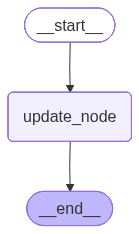

Initial state: {'name': 'Alice', 'age': 30}
---Updating Age Node---
Final state: {'name': 'Alice', 'age': 31}


In [51]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from IPython.display import Image, display

# 1. Define a new TypedDict for the state
class SimpleState(TypedDict):
    name: str
    age: int

# 2. Define a simple node function
def update_age_node(state: SimpleState) -> dict:
    print("---Updating Age Node---")
    # 3. Inside the node function, update the value of one of the state keys
    # Do not include a reducer for this key in the state definition.
    updated_age = state['age'] + 1
    return {"age": updated_age}

# 4. Build a StateGraph with the new state definition and add the node
builder = StateGraph(SimpleState)
builder.add_node("update_node", update_age_node)

# 5. Add an edge from START to the node and from the node to END
builder.add_edge(START, "update_node")
builder.add_edge("update_node", END)

# 6. Compile the graph
graph = builder.compile()

# Display the graph
print("\nGraph for Default Overwriting State:")
display(Image(graph.get_graph().draw_mermaid_png()))

# 7. Invoke the compiled graph with an initial state
initial_state = {"name": "Alice", "age": 30}
print(f"Initial state: {initial_state}")
result = graph.invoke(initial_state)

# 8. Print the output
print(f"Final state: {result}")

## Branching example




Graph for Branching (Parallel Update Conflict leading to InvalidUpdateError):


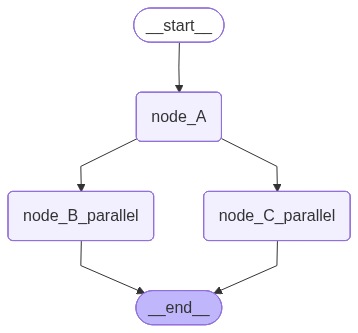


Attempting to invoke graph with initial state: {'shared_value': 5}
---Node A (Initial)---
---Node B (Parallel Update)---
---Node C (Parallel Update)---

Caught expected InvalidUpdateError: At key 'shared_value': Can receive only one value per step. Use an Annotated key to handle multiple values.
For troubleshooting, visit: https://python.langchain.com/docs/troubleshooting/errors/INVALID_CONCURRENT_GRAPH_UPDATE


In [52]:
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.errors import InvalidUpdateError
from IPython.display import Image, display


# 1. Define a new TypedDict for the state that will be used in the branching example,
#    including a key that will be updated concurrently by multiple nodes.
class ConflictingState(TypedDict):
    shared_value: int # This key will be updated concurrently

# 2. Define at least three node functions. The first node should set up a condition
def node_A(state: ConflictingState) -> dict:
    print("---Node A (Initial)---")
    # This node simply passes the state along and doesn't directly cause the conflict,
    # the conflict arises from the graph structure (parallel edges from A).
    return {"shared_value": state['shared_value'] + 1}

def node_B_parallel(state: ConflictingState) -> dict:
    print("---Node B (Parallel Update)---")
    # Attempts to update the 'shared_value' key using default overwriting
    return {"shared_value": state['shared_value'] + 10}

def node_C_parallel(state: ConflictingState) -> dict:
    print("---Node C (Parallel Update)---")
    # Attempts to update the 'shared_value' key using default overwriting
    # This update conflicts with the update from node_B_parallel
    return {"shared_value": state['shared_value'] + 20}

# 3. Build a StateGraph using the new state definition and add all the defined nodes.
builder = StateGraph(ConflictingState)
builder.add_node("node_A", node_A)
builder.add_node("node_B_parallel", node_B_parallel)
builder.add_node("node_C_parallel", node_C_parallel)

# 4. Add edges to the graph such that a single node execution leads to multiple
#    nodes attempting to update the same state key concurrently.
#    Add edges from START to node_A, and then two parallel edges from node_A
#    to node_B_parallel and node_C_parallel.
builder.add_edge(START, "node_A")
builder.add_edge("node_A", "node_B_parallel") # First parallel edge
builder.add_edge("node_A", "node_C_parallel") # Second parallel edge - this causes the conflict

# Add edges from the parallel nodes to END
builder.add_edge("node_B_parallel", END)
builder.add_edge("node_C_parallel", END)


# 5. Compile the graph.
graph = builder.compile()

# Display the graph for the conflicting parallel update example
print("\nGraph for Branching (Parallel Update Conflict leading to InvalidUpdateError):")
display(Image(graph.get_graph().draw_mermaid_png()))

initial_state = {"shared_value": 5}
print(f"\nAttempting to invoke graph with initial state: {initial_state}")

try:
    graph.invoke(initial_state)
except InvalidUpdateError as e:
    # 7. Inside the except block, print the error message to demonstrate that
    #    the InvalidUpdateError was caught due to the conflicting concurrent updates.
    print(f"\nCaught expected InvalidUpdateError: {e}")


## Reducers example



Graph for Annotated with operator.mul:


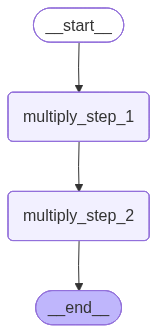

Initial state: {'total_value': 5, 'step_count': 0}
---Multiply Node: Current total_value = 0---
---Another Multiply Node: Current total_value = 0---
Final state: {'total_value': 0, 'step_count': 2}

Initial state: {'total_value': 1, 'step_count': 10}
---Multiply Node: Current total_value = 0---
---Another Multiply Node: Current total_value = 0---
Final state: {'total_value': 0, 'step_count': 12}


In [53]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from operator import mul # Import the multiplication operator as a reducer
from IPython.display import Image, display

# 1. Define a TypedDict for the state with at least one key annotated with a custom reducer.
#    Use operator.mul as the reducer and an integer data type.
class MultiplierState(TypedDict):
    # Annotated key with the multiplication reducer
    total_value: Annotated[int, mul]
    step_count: int

# 2. Define at least one node function that returns an update for the annotated state key.
def multiply_node(state: MultiplierState) -> dict:
    print(f"---Multiply Node: Current total_value = {state['total_value']}---")
    # Return an update for the 'total_value' by multiplying it by a factor
    # Also increment the step count
    multiplier = 2
    return {"total_value": multiplier, "step_count": state['step_count'] + 1}

def another_multiply_node(state: MultiplierState) -> dict:
    print(f"---Another Multiply Node: Current total_value = {state['total_value']}---")
    # Return another update for the 'total_value' by multiplying it by a different factor
    multiplier = 3
    return {"total_value": multiplier, "step_count": state['step_count'] + 1}

# 3. Build a StateGraph using the defined state and node(s).
builder = StateGraph(MultiplierState)
builder.add_node("multiply_step_1", multiply_node)
builder.add_node("multiply_step_2", another_multiply_node)


# 4. Add appropriate edges to the graph (e.g., from START to the node, and from the node to END).
builder.add_edge(START, "multiply_step_1")
builder.add_edge("multiply_step_1", "multiply_step_2") # Chain the nodes to see multiple applications of the reducer
builder.add_edge("multiply_step_2", END)

# 5. Compile the graph.
graph = builder.compile()

# Display the graph
print("\nGraph for Annotated with operator.mul:")
display(Image(graph.get_graph().draw_mermaid_png()))

# 6. Invoke the compiled graph with an initial state that includes a value for the annotated key.
#    The initial value for 'total_value' will be used as the starting point for multiplication.
initial_state = {"total_value": 5, "step_count": 0}
print(f"Initial state: {initial_state}")
result = graph.invoke(initial_state)

# 8. Print the output of the graph invocation to demonstrate the effect of the custom reducer on the state.
print(f"Final state: {result}")

# Invoke again with a different initial value
initial_state_2 = {"total_value": 1, "step_count": 10}
print(f"\nInitial state: {initial_state_2}")
result_2 = graph.invoke(initial_state_2)
print(f"Final state: {result_2}")

## Custom reducers example


Graph for Custom Reducers:


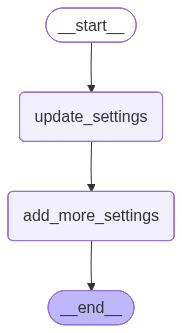

Initial state: {'settings': {'theme': 'light'}, 'status': 'initial', 'log': ['start']}
---Updating Settings Node---
---Adding More Settings Node---
Final state: {'settings': {'theme': 'dark', 'language': 'fr', 'notifications': 'off'}, 'status': 'settings_updated', 'log': ['start', 'settings updated', 'more settings added']}

Initial state (settings=None): {'settings': None, 'status': 'initial', 'log': ['start_none']}
---Updating Settings Node---
---Adding More Settings Node---
Final state (settings=None): {'settings': {'theme': 'dark', 'language': 'fr', 'notifications': 'off'}, 'status': 'settings_updated', 'log': ['start_none', 'settings updated', 'more settings added']}


In [56]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from operator import add # Keep add for the log key
from IPython.display import Image, display # Keep imports

# 1. Define a TypedDict for the state with at least one key annotated with a custom reducer.
#    The key should hold a data structure other than a list or a simple integer/string (e.g., a dictionary).
def merge_dictionaries(left: dict | None, right: dict | None) -> dict:
    """Custom reducer to merge two dictionaries. Handles None inputs."""
    left = left if left is not None else {}
    right = right if right is not None else {}
    # Merge dictionaries, with values from 'right' overwriting values from 'left' in case of shared keys
    return {**left, **right}

class ComplexState(TypedDict):
    # Annotated key with the custom dictionary merging reducer
    settings: Annotated[dict[str, str], merge_dictionaries]
    status: str
    # Corrected reducer for the log key to use operator.add for list concatenation
    log: Annotated[list[str], add]

# 2. Define at least one node function that returns an update for the annotated state key.
def update_settings_node(state: ComplexState) -> dict:
    print("---Updating Settings Node---")
    # Return an update for the 'settings' dictionary and add a log entry
    new_settings = {"theme": "dark", "language": "en"}
    # Return a list for the log update so operator.add can concatenate it
    return {"settings": new_settings, "status": "settings_updated", "log": ["settings updated"]}

def add_more_settings_node(state: ComplexState) -> dict:
    print("---Adding More Settings Node---")
    # Return another update for the 'settings' dictionary
    more_settings = {"language": "fr", "notifications": "off"}
     # Return a list for the log update
    return {"settings": more_settings, "log": ["more settings added"]}


# 3. Build a StateGraph using the defined state and node(s).
builder = StateGraph(ComplexState)
builder.add_node("update_settings", update_settings_node)
builder.add_node("add_more_settings", add_more_settings_node)

# 4. Add appropriate edges to the graph (e.g., from START to the node, and from the node to END).
builder.add_edge(START, "update_settings")
builder.add_edge("update_settings", "add_more_settings") # Chain the nodes to see multiple updates
builder.add_edge("add_more_settings", END)

# 5. Compile the graph.
graph = builder.compile()

# Display the graph
print("\nGraph for Custom Reducers:")
display(Image(graph.get_graph().draw_mermaid_png()))

# 6. Invoke the compiled graph with an initial state that includes a value for the annotated key.
initial_state = {"settings": {"theme": "light"}, "status": "initial", "log": ["start"]}
print(f"Initial state: {initial_state}")
result = graph.invoke(initial_state)

# 8. Print the output of the graph invocation to demonstrate the effect of the custom reducer on the state.
print(f"Final state: {result}")

# Invoke again with None for settings to show None handling
initial_state_none = {"settings": None, "status": "initial", "log": ["start_none"]}
print(f"\nInitial state (settings=None): {initial_state_none}")
result_none = graph.invoke(initial_state_none)
print(f"Final state (settings=None): {result_none}")

## `add messages` example


Graph for add_messages Example:


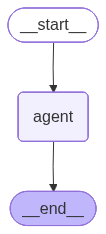

Initial messages: [HumanMessage(content='I need help with my order.', additional_kwargs={}, response_metadata={})]
---Agent Response Node---
Final state: {'messages': [HumanMessage(content='I need help with my order.', additional_kwargs={}, response_metadata={}, id='a54df223-5a53-4ff5-8877-1d762b3678b3'), AIMessage(content='Acknowledged. Processing your request.', additional_kwargs={}, response_metadata={}, id='619ab986-2eac-4b16-870f-3f4b1bd9326e')]}


In [57]:
from langgraph.graph import StateGraph, START, END, MessagesState
from langchain_core.messages import HumanMessage, AIMessage
from IPython.display import Image, display

# 1. Define a node function that takes MessagesState as input and returns new messages
def agent_response_node(state: MessagesState) -> MessagesState:
    print("---Agent Response Node---")
    # The node returns a dictionary with the 'messages' key containing a list of new messages
    # The add_messages reducer will append these to the existing messages list in the state
    # Return different messages than the original example
    return {"messages": [AIMessage(content="Acknowledged. Processing your request.")]}

# 3. Build a StateGraph using MessagesState as the state definition
builder = StateGraph(MessagesState)

# 4. Add the defined node to the graph
builder.add_node("agent", agent_response_node)

# 5. Add an edge from START to the node and from the node to END
builder.add_edge(START, "agent")
builder.add_edge("agent", END)

# 6. Compile the graph
graph = builder.compile()

# Display the graph
print("\nGraph for add_messages Example:")
display(Image(graph.get_graph().draw_mermaid_png()))


# 7. Invoke the compiled graph with an initial state containing messages
# Use different initial messages than the original example
initial_messages = [HumanMessage(content="I need help with my order.")]
print(f"Initial messages: {initial_messages}")

result = graph.invoke({"messages": initial_messages})

# 8. Print the output of the graph invocation
print(f"Final state: {result}")

## Message overwriting example


Initial messages: [HumanMessage(content='Hello there!', additional_kwargs={}, response_metadata={}, name='UserA', id='user_msg_1'), AIMessage(content='Hi UserA, how can I help?', additional_kwargs={}, response_metadata={}, name='BotB', id='bot_msg_1'), HumanMessage(content='I have a follow-up question.', additional_kwargs={}, response_metadata={}, name='UserC', id='user_msg_2')]
New messages to add: [AIMessage(content="I'm ready to assist, UserA.", additional_kwargs={}, response_metadata={}, name='BotB_Updated', id='bot_msg_1'), HumanMessage(content='Can you tell me about X?', additional_kwargs={}, response_metadata={}, name='UserD', id='user_msg_3')]
Combined messages after add_messages (demonstrating overwrite): [HumanMessage(content='Hello there!', additional_kwargs={}, response_metadata={}, name='UserA', id='user_msg_1'), AIMessage(content="I'm ready to assist, UserA.", additional_kwargs={}, response_metadata={}, name='BotB_Updated', id='bot_msg_1'), HumanMessage(content='I have a 

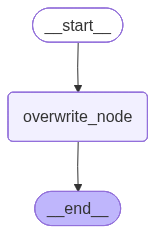

Invoking graph to demonstrate overwrite:
---Overwrite Graph Node---
Final state after graph invocation: {'messages': [HumanMessage(content='Hello there!', additional_kwargs={}, response_metadata={}, name='UserA', id='user_msg_1'), AIMessage(content='Hi UserA, how can I help?', additional_kwargs={}, response_metadata={}, name='BotB', id='bot_msg_1'), HumanMessage(content='My follow-up is about topic Y.', additional_kwargs={}, response_metadata={}, name='UserC_Updated', id='user_msg_2')]}


In [58]:
# 1. Import necessary classes: add_messages, AIMessage, HumanMessage, RemoveMessage.
from langgraph.graph.message import add_messages
from langchain_core.messages import AIMessage, HumanMessage
from langgraph.graph import StateGraph, START, END, MessagesState
from IPython.display import Image, display # Import Image and display

# 2. Create an initial list of messages with unique IDs and some content.
# Use different messages than the original example.
initial_messages_overwrite = [
    HumanMessage(content="Hello there!", name="UserA", id="user_msg_1"),
    AIMessage(content="Hi UserA, how can I help?", name="BotB", id="bot_msg_1"),
    HumanMessage(content="I have a follow-up question.", name="UserC", id="user_msg_2"),
]
print(f"Initial messages: {initial_messages_overwrite}")

# 3. Create a new list of messages containing at least one message with an ID that matches an ID in the initial list,
# but with different content or attributes. Include at least one message with a new, unique ID.
# Use different messages than the original example.
new_messages_overwrite = [
    # This message has the same ID as the second message in initial_messages_overwrite, will overwrite
    AIMessage(content="I'm ready to assist, UserA.", name="BotB_Updated", id="bot_msg_1"),
    # This message has a new, unique ID and should be appended.
    HumanMessage(content="Can you tell me about X?", name="UserD", id="user_msg_3"),
]
print(f"New messages to add: {new_messages_overwrite}")

# 4. Call the add_messages function with the initial message list as the first argument and the new message list as the second argument.
combined_messages_overwrite = add_messages(initial_messages_overwrite, new_messages_overwrite)

# 5. Print the resulting message list to demonstrate that the message with the matching ID was overwritten and the message with the new ID was appended.
print(f"Combined messages after add_messages (demonstrating overwrite): {combined_messages_overwrite}")

# Add a simple graph to demonstrate message overwriting within a graph context
# 6. Define a simple node function that takes MessagesState and returns a list containing an AIMessage with an ID matching one in the initial list, but with new content, to demonstrate overwriting within a graph.
def overwrite_graph_node(state: MessagesState) -> MessagesState:
    print("---Overwrite Graph Node---")
    # Return a message with an existing ID ("user_msg_2") to demonstrate overwriting within the graph
    return {"messages": [HumanMessage(content="My follow-up is about topic Y.", name="UserC_Updated", id="user_msg_2")]}

# 7. Build a StateGraph using MessagesState as the state definition and add the defined node.
builder = StateGraph(MessagesState)
builder.add_node("overwrite_node", overwrite_graph_node)

# 8. Add an edge from START to the node and from the node to END.
builder.add_edge(START, "overwrite_node")
builder.add_edge("overwrite_node", END)

# 9. Compile the graph.
graph_overwrite = builder.compile()

# 10. Display the graph using graph.get_graph().draw_mermaid_png().
print("\nGraph for Message Overwriting Example:")
display(Image(graph_overwrite.get_graph().draw_mermaid_png()))

# 11. Invoke the compiled graph with the initial messages list.
print("Invoking graph to demonstrate overwrite:")
result_overwrite_graph = graph_overwrite.invoke({"messages": initial_messages_overwrite})

# 12. Print the final state after the graph invocation to show the message overwriting in a graph context.
print(f"Final state after graph invocation: {result_overwrite_graph}")

## Message removal example


Initial messages: [HumanMessage(content='Query about product pricing.', additional_kwargs={}, response_metadata={}, name='Customer', id='cust_msg_1'), AIMessage(content='Here is the pricing information.', additional_kwargs={}, response_metadata={}, name='SupportBot', id='bot_msg_1'), HumanMessage(content='I also need shipping details.', additional_kwargs={}, response_metadata={}, name='Customer', id='cust_msg_2'), AIMessage(content='Shipping details are available on our website.', additional_kwargs={}, response_metadata={}, name='SupportBot', id='bot_msg_2')]
Messages to remove: [RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='cust_msg_1'), RemoveMessage(content='', additional_kwargs={}, response_metadata={}, id='bot_msg_2')]
Remaining messages after removal: [AIMessage(content='Here is the pricing information.', additional_kwargs={}, response_metadata={}, name='SupportBot', id='bot_msg_1'), HumanMessage(content='I also need shipping details.', additional_kwar

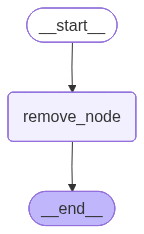

Invoking graph to demonstrate message removal:
---Remove Messages Graph Node---
Final state after graph invocation: {'messages': [HumanMessage(content='Query about product pricing.', additional_kwargs={}, response_metadata={}, name='Customer', id='cust_msg_1'), HumanMessage(content='I also need shipping details.', additional_kwargs={}, response_metadata={}, name='Customer', id='cust_msg_2'), AIMessage(content='Shipping details are available on our website.', additional_kwargs={}, response_metadata={}, name='SupportBot', id='bot_msg_2')]}


In [59]:
# 1. Import necessary classes: add_messages, AIMessage, HumanMessage, and RemoveMessage.
from langgraph.graph.message import add_messages
from langchain_core.messages import AIMessage, HumanMessage, RemoveMessage
from langgraph.graph import StateGraph, START, END, MessagesState # Import StateGraph and MessagesState
from IPython.display import Image, display # Import Image and display


# 2. Create an initial list of messages with unique IDs and some content.
# Use different messages and IDs than the original example.
initial_messages_remove = [
    HumanMessage(content="Query about product pricing.", name="Customer", id="cust_msg_1"),
    AIMessage(content="Here is the pricing information.", name="SupportBot", id="bot_msg_1"),
    HumanMessage(content="I also need shipping details.", name="Customer", id="cust_msg_2"),
    AIMessage(content="Shipping details are available on our website.", name="SupportBot", id="bot_msg_2"),
]
print(f"Initial messages: {initial_messages_remove}")

# 3. Create a new list containing RemoveMessage instances for some of the IDs in the initial list.
# Select different messages for removal compared to the original example.
# Let's remove the first and fourth messages (ids "cust_msg_1" and "bot_msg_2").
messages_to_remove = [
    RemoveMessage(id="cust_msg_1"),
    RemoveMessage(id="bot_msg_2"),
]
print(f"Messages to remove: {messages_to_remove}")

# 4. Call the add_messages function with the initial message list as the first argument and the list of RemoveMessage instances as the second argument.
remaining_messages = add_messages(initial_messages_remove, messages_to_remove)

# 5. Print the resulting message list to demonstrate that the messages with the specified IDs were removed.
print(f"Remaining messages after removal: {remaining_messages}")


# Add a simple graph to demonstrate message removal within a graph context
# 6. Define a simple node function that takes MessagesState and returns a list containing RemoveMessage instances
# for some of the message IDs to demonstrate message removal within a graph.
# Use different IDs for removal in this node compared to the previous steps.
def remove_messages_graph_node(state: MessagesState) -> MessagesState:
    print("---Remove Messages Graph Node---")
    # Return a list of RemoveMessage instances to remove messages from the state
    # Let's remove the second message by ID ("bot_msg_1")
    return {"messages": [RemoveMessage(id="bot_msg_1")]}

# 7. Build a StateGraph using MessagesState as the state definition and add the defined node.
builder = StateGraph(MessagesState)
builder.add_node("remove_node", remove_messages_graph_node)

# 8. Add an edge from START to the node and from the node to END.
builder.add_edge(START, "remove_node")
builder.add_edge("remove_node", END)

# 9. Compile the graph.
graph_remove = builder.compile()

# 10. Display the graph using graph.get_graph().draw_mermaid_png().
print("\nGraph for Message Removal Example:")
display(Image(graph_remove.get_graph().draw_mermaid_png()))

# 11. Invoke the compiled graph with the initial messages list created in step 2.
print("Invoking graph to demonstrate message removal:")
result_remove_graph = graph_remove.invoke({"messages": initial_messages_remove})

# 12. Print the final state after the graph invocation to show the message removal in a graph context.
print(f"Final state after graph invocation: {result_remove_graph}")